<a href="https://colab.research.google.com/github/danwein8/Deep-Q-Network-Agents/blob/main/AtariDQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    from google.colab import drive
    %tensorflow_version 2.x
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

if COLAB:
  !sudo apt-get install -y xvfb ffmpeg
  !pip install -q ale-py
  !pip install -q 'gym==0.17.3'
  !pip install -q 'imageio==2.4.0'
  !pip install -q PILLOW
  !pip install -q 'pyglet==1.3.2'
  !pip install -q pyvirtualdisplay
  !pip install -q --upgrade tensorflow-probability
  !pip install -q 'tf-agents==0.12.0'

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Note: using Google CoLab
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 24 not upgraded.
Need to get 7,697 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/main amd64 libfontenc1 amd64 1:1.1.4-0ubuntu1 [14.0 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/main amd64 libxfont2 amd64 1:2.0.3-1 [91.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/main amd64 libxkbfile1

In [2]:
import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym, suite_atari
from tf_agents.environments import tf_py_environment
from tf_agents.environments import batched_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network, network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.networks import categorical_q_network

from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts

# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()


In [3]:
# 10K already takes awhile to complete, with minimal results.
# To get an effective agent requires much more.
# The number of episodes to train over. Increase this for more complex problems; however, training time also increases.
num_iterations = 200000

# How many initial random steps, before training start, to
# collect initial data.
initial_collect_steps = 2000
# How many steps should we run each iteration to collect
# data from.
collect_steps_per_iteration = 10
# How much data should we store for training examples.
replay_buffer_max_length = 100000

batch_size = 32
# The rate at which previous Q-values are updated based on new episodes run during training.
learning_rate = 2.5e-3
# How often should the program provide an update.
log_interval = 1000

# How many episodes should the program use for each evaluation.
num_eval_episodes = 25
# How often should an evaluation occur.
eval_interval = 2500


In [4]:
!pip install gym[atari]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.6/540.6 kB 18.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for atari-py: filename=atari_py-0.2.9-cp310-cp310-linux_x86_64.whl size=2856174 sha256=d28e3bf25c92b27ace2cfe3c6cd8dfe302c7a5dd6bd8cd9d1d9ce3d2380e1c5c
  Stored in directory: /root/.cache/pip/wheels/75/6f/04/1f3bf5255580101e16ff487564354dddcdd23ec3b43b775b7a
Successfully built atari-py


In [5]:
# HIDE OUTPUT
! wget http://www.atarimania.com/roms/Roms.rar
! mkdir /content/ROM/
! unrar e -o+ /content/Roms.rar /content/ROM/
! python -m atari_py.import_roms /content/ROM/

Streaming output truncated to the last 5000 lines.
Extracting  /content/ROM/3D Tic-Tac-Toe (32 in 1) (1988) (Atari, Carol Shaw) (CX26163P) (PAL).bin       1%  OK 
Extracting  /content/ROM/4 Game in One - Ice Hockey, Phantom UFO, Spy Vs. Spy, Cosmic Avenger (1983) (Bit Corporation) (PAL).bin       1%  OK 
Extracting  /content/ROM/4 Game in One - Rodeo Champ, Open Sesame, Bobby Is Going Home, Festival (1983) (Bit Corporation) (P460) (PAL).bin       1%  OK 
Extracting  /content/ROM/4 in 1 - Canyon Bomber, Home Run, Night Driver, Sky Diver (02-19-1987) (Atari) (CX26137) (Prototype).bin       1%  OK 
Extracting  /content/ROM/8 in 1 (Supergames 8 in 1) (01-16-92) (Atari) (CX26193) (Prototype).bin       1%  OK 
Extracting  /content/ROM/========  ROM HUNTER'S 1977-1992 VCS ROMS COLLECTION V18  ========.txt       1%  OK 
Extracting  /content/ROM/A-Team, The (AKA Saboteur) (03-30-1984) (Atari, Jerome Domurat, Howard Scott Warshaw) (CX26133) (

In [6]:
#env_name = 'Breakout-v4'
#env_name = 'Pong-v0'
#env_name = 'BreakoutDeterministic-v4'
#env_name = 'Asteroids-v4'
#env_name = 'MarioBros.-v4'
env_name = 'SpaceInvaders-v4'
#env = suite_gym.load(env_name)

# AtariPreprocessing runs 4 frames at a time, max-pooling over the last 2
# frames. We need to account for this when computing things like update
# intervals.
ATARI_FRAME_SKIP = 4

max_episode_frames=108000  # ALE frames

env = suite_atari.load(
    env_name,
    max_episode_steps=max_episode_frames / ATARI_FRAME_SKIP,
    gym_env_wrappers=suite_atari.DEFAULT_ATARI_GYM_WRAPPERS_WITH_STACKING)
#env = batched_py_environment.BatchedPyEnvironment([env])

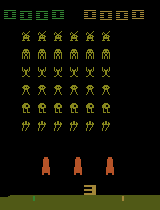

In [7]:
env.reset()
PIL.Image.fromarray(env.render())


In [8]:
train_py_env = suite_atari.load(
    env_name,
    max_episode_steps=max_episode_frames / ATARI_FRAME_SKIP,
    gym_env_wrappers=suite_atari.DEFAULT_ATARI_GYM_WRAPPERS_WITH_STACKING)

eval_py_env = suite_atari.load(
    env_name,
    max_episode_steps=max_episode_frames / ATARI_FRAME_SKIP,
    gym_env_wrappers=suite_atari.DEFAULT_ATARI_GYM_WRAPPERS_WITH_STACKING)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)


In [9]:
# AtariPreprocessing runs 4 frames at a time, max-pooling over the last 2
# frames. We need to account for this when computing things like update
# intervals.
ATARI_FRAME_SKIP = 4


class AtariCategoricalQNetwork(network.Network):
    """CategoricalQNetwork subclass that divides observations by 255."""

    def __init__(self, input_tensor_spec, action_spec, **kwargs):
        super(AtariCategoricalQNetwork, self).__init__(
            input_tensor_spec, state_spec=())
        input_tensor_spec = tf.TensorSpec(
            dtype=tf.float32, shape=input_tensor_spec.shape)
        self._categorical_q_network = \
            categorical_q_network.CategoricalQNetwork(
                input_tensor_spec, action_spec, **kwargs)

    @property
    def num_atoms(self):
        return self._categorical_q_network.num_atoms

    def call(self, observation, step_type=None, network_state=()):
        state = tf.cast(observation, tf.float32)
        # We divide the grayscale pixel values by 255 here rather than
        # storing normalized values beause uint8s are 4x cheaper to
        # store than float32s.
        # TODO(b/129805821): handle the division by 255 for
        # train_eval_atari.py in
        # a preprocessing layer instead.
        state = state / 255
        return self._categorical_q_network(
            state, step_type=step_type, network_state=network_state)

In [10]:
fc_layer_params = (512,)
conv_layer_params = ((32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1))

q_net = AtariCategoricalQNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    conv_layer_params=conv_layer_params,
    fc_layer_params=fc_layer_params)


In [11]:
optimizer = tf.compat.v1.train.RMSPropOptimizer(
    learning_rate=learning_rate,
    decay=0.95,
    momentum=0.0,
    epsilon=0.00001,
    centered=True)

train_step_counter = tf.Variable(0)

observation_spec = tensor_spec.from_spec(train_env.observation_spec())
time_step_spec = ts.time_step_spec(observation_spec)

action_spec = tensor_spec.from_spec(train_env.action_spec())
target_update_period = 32000  # ALE frames
update_period = 16  # ALE frames
_update_period = update_period / ATARI_FRAME_SKIP


agent = categorical_dqn_agent.CategoricalDqnAgent(
    time_step_spec,
    action_spec,
    categorical_q_network=q_net,
    optimizer=optimizer,
    # epsilon_greedy=epsilon,
    n_step_update=1.0,
    target_update_tau=1.0,
    target_update_period=(
        target_update_period / ATARI_FRAME_SKIP / _update_period),
    gamma=0.99,
    reward_scale_factor=1.0,
    gradient_clipping=None,
    debug_summaries=False,
    summarize_grads_and_vars=False)

agent.initialize()


In [12]:
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]


# See also the metrics module for standard implementations of
# different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

In [13]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)


Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [14]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())


def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step,\
                                      next_time_step)

    # Add trajectory to the replay buffer
    buffer.add_batch(traj)


def collect_data(env, policy, buffer, steps):
    for _ in range(steps):
        collect_step(env, policy, buffer)


collect_data(train_env, random_policy, replay_buffer,
             steps=initial_collect_steps)

In [15]:
iterator = iter(dataset)

# (Optional) Optimize by wrapping some of the code in a graph
# using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy,
                                num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

    # Collect a few steps using collect_policy and 
    # save to the replay buffer.
    for _ in range(collect_steps_per_iteration):
        collect_step(train_env, agent.collect_policy, replay_buffer)

    # Sample a batch of data from the buffer and 
    # update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy,
                                        num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)


step = 1000: loss = 3.9366092681884766
step = 2000: loss = 3.9381103515625
step = 2500: Average Return = 344.20001220703125
step = 3000: loss = 3.914142608642578
step = 4000: loss = 3.8797976970672607
step = 5000: loss = 3.7998762130737305
step = 5000: Average Return = 240.60000610351562
step = 6000: loss = 3.6723251342773438
step = 7000: loss = 3.8030409812927246
step = 7500: Average Return = 239.8000030517578
step = 8000: loss = 3.6568593978881836
step = 9000: loss = 3.411536455154419
step = 10000: loss = 3.3609702587127686
step = 10000: Average Return = 267.0
step = 11000: loss = 3.4394896030426025
step = 12000: loss = 3.4031124114990234
step = 12500: Average Return = 252.60000610351562
step = 13000: loss = 3.1779446601867676
step = 14000: loss = 3.134566307067871
step = 15000: loss = 3.0051841735839844
step = 15000: Average Return = 228.39999389648438
step = 16000: loss = 2.809809684753418
step = 17000: loss = 3.2843384742736816
step = 17500: Average Return = 290.6000061035156
step

In [16]:
def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename, 'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

    return IPython.display.HTML(tag)


def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            time_step = eval_env.reset()
            video.append_data(eval_py_env.render())
            while not time_step.is_last():
                action_step = policy.action(time_step)
                time_step = eval_env.step(action_step.action)
                video.append_data(eval_py_env.render())
    return embed_mp4(filename)


In [17]:
# HIDE OUTPUT
create_policy_eval_video(agent.policy, "trained-agent")


In [18]:
# HIDE OUTPUT
create_policy_eval_video(random_policy, "random-agent")
